# Function Optimization using a genetic algorithm

The task presented in this notebook is to find the best parameters for a given function using a genetic algorithm.

The defined functions are:
* Himmelbau function: $f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$
  
* Rosenbrock function: $f(x, y) = (1 - x)^2 + 100 \cdot (y - x^2)^2$

These functions are oftenly used to evaluate the performance of optimization algorithms.

## Import libraries

In [12]:
import random

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Define and plot the functions

In [13]:
def rosenbrock(x, y):
    return (1-x)**2 + 100 * (y - x**2)**2

def himmelbau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

In [14]:
fn_dict = {
    'rosenbrock': {
        'function': rosenbrock,
        'nb_params': 2,
        'interval': {
            'lower': -5,
            'upper': 5
        }
    },
    'himmelbau': {
        'function': himmelbau,
        'nb_params': 2,
        'interval': {
            'lower': -5,
            'upper': 5
        }
    }
}

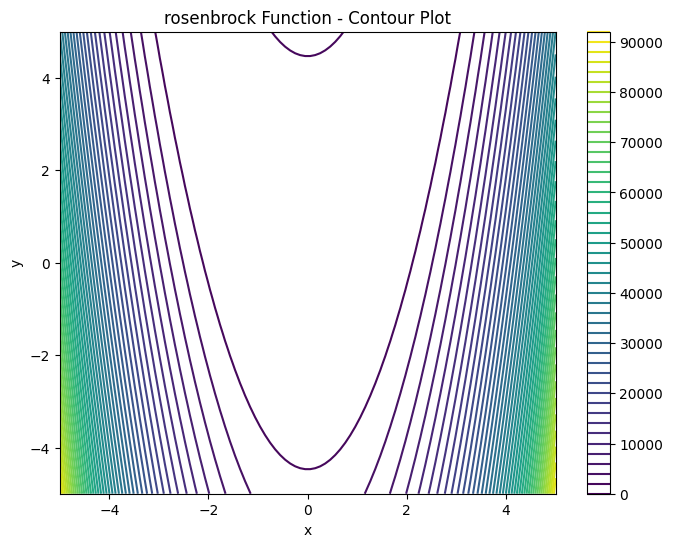

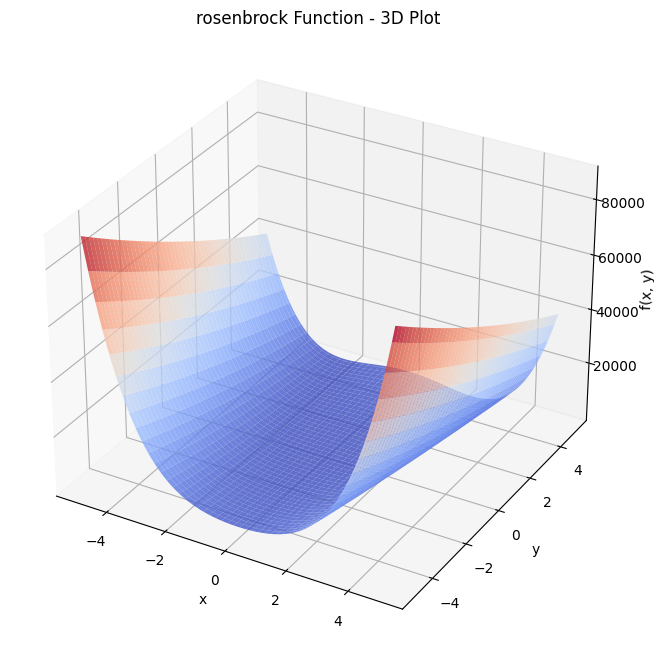

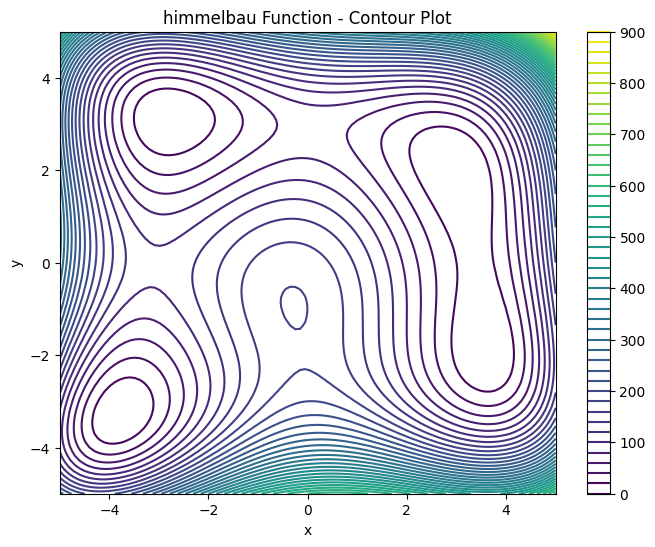

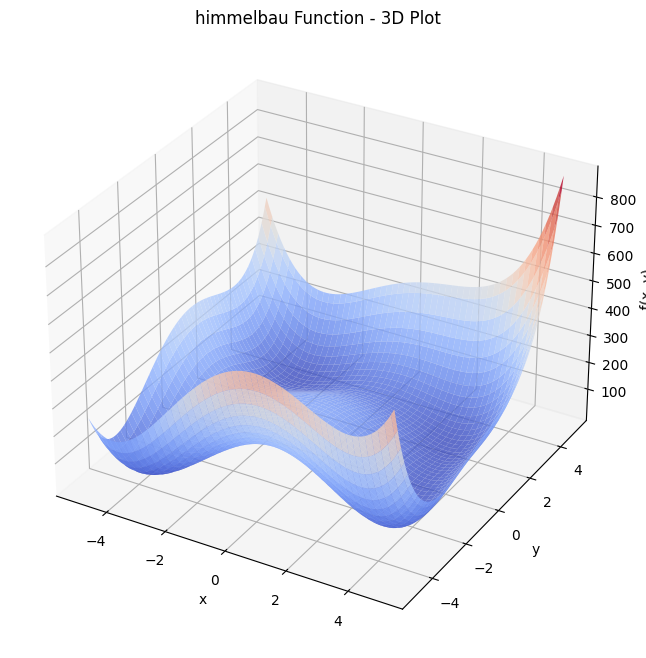

In [17]:
for fn_key, v in fn_dict.items():
    fn, nb_params, lower, upper = v['function'], v['nb_params'], v['interval']['lower'], v['interval']['upper']
    
    # 2D Plot
    x_vals = np.linspace(lower, upper, 100)
    y_vals = np.linspace(lower, upper, 100)
    X, Y = np.meshgrid(x_vals, y_vals)
    if nb_params == 1:
        Z = fn(X)
    else:
        Z = fn(X, Y)
    
    plt.figure(figsize=(8, 6))
    contour = plt.contour(X, Y, Z, levels=50, cmap='viridis')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'{fn.__name__} Function - Contour Plot')
    plt.colorbar(contour)
    plt.show()
    
    # 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.8)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')
    ax.set_title(f'{fn.__name__} Function - 3D Plot')
    plt.show()

## Creating the genetic algorithm

First, we define what an individual is with a class. An individual is basically an element of the population, which is similar to a chromosome. Thus, each individual (i.e. chromosome) will embed $x$ genes. Where, $x$ is the number of parameters of the given function.

The goal of a genetic algorithm is to create individuals that minimize a measure of fitness. Here, we'll try to find the best parameters (i.e. genes) in order to minimize the function. The result of the function according to the parameters is our metrics of fitness.

In [28]:
class Individual:
    def __init__(self, chromosome, fn_dict, fn_key):
        self.chromosome = chromosome

        self.fn = fn_dict[fn_key]['function']
        self.fn_dict = fn_dict
        self.fn_key = fn_key
        self.nb_params = fn_dict[fn_key]['nb_params']

        self.lower_bound = fn_dict[fn_key]['interval']['lower']
        self.upper_bound = fn_dict[fn_key]['interval']['upper']
        
        self.fitness = self.cal_fitness()

    @classmethod
    def mutated_genes(self, lower, upper):
        gene = round(random.uniform(lower, upper), 2)
        return gene

    @classmethod
    def create_gnome(self, lower, upper, nb_params):
        return [self.mutated_genes(lower, upper) for _ in range(nb_params)]

    def mate(self, par2):
        child_chromosome = []
        for gp1, gp2 in zip(self.chromosome, par2.chromosome):
            prob = random.random()

            if prob < 0.45:
                child_chromosome.append(gp1)
            elif prob < 0.9:
                child_chromosome.append(gp2)
            else:
                child_chromosome.append(self.mutated_genes(
                    self.lower_bound, self.upper_bound
                ))
        
        return Individual(child_chromosome, self.fn_dict, self.fn_key)

    def cal_fitness(self):
        return self.fn(*self.chromosome)

Now, we can define an individual by setting genes by default (e.g. 153 and 3). We also specify the function.
We can then print the chromosome and the fitness.

In [30]:
i = Individual([135, 3], fn_dict, 'himmelbau')
print("Chromosome:", i.chromosome)
print("Fitness", i.fitness)

Chromosome: [135, 3]
Fitness 331877858


The method `create_gnome` of our individual creates a new random chromosome.

In [31]:
i.create_gnome(i.lower_bound, i.upper_bound, i.nb_params)

[4.81, -4.85]

Below is the iteration loop of our genetic algorithm. Let's try with the *rosenbrock* function.

In [63]:
generation = 1
found = False
population = []

POPULATION_SIZE = 100

# Change the parameters here
fn_key = 'rosenbrock'

generation_fitnesses = []

for _ in range(POPULATION_SIZE):
    gnome = Individual.create_gnome(
        fn_dict[fn_key]['interval']['lower'],
        fn_dict[fn_key]['interval']['upper'],
        fn_dict[fn_key]['nb_params'],
    )
    population.append(Individual(gnome, fn_dict, fn_key))

while not found:
    population = sorted(population, key = lambda x: x.fitness)

    generation_fitnesses.append(population[0].fitness)

    # We define that the function is optimized if its value is near 0.
    if abs(population[0].fitness) <= 0.001:
        found = True
        break

    new_generation = []

    s = int((10*POPULATION_SIZE) / 100)
    new_generation.extend(population[:s])

    s = int((90*POPULATION_SIZE) / 100)
    for _ in range(s):
        parent1 = random.choice(population[:50])
        parent2 = random.choice(population[:50])
        child = parent1.mate(parent2)
        new_generation.append(child)

    population = new_generation
    # print(f"Generation: {generation}\tParameters: {population[0].chromosome}\tFitness: {population[0].fitness}")

    generation += 1

print(f"Generation: {generation}\tParameters: {population[0].chromosome}\tFitness: {population[0].fitness}")

Generation: 18110	Parameters: [0.98, 0.96]	Fitness: 0.0004159999999999972


In [64]:
print(f"The chromosome {population[0].chromosome} achieved a fitness of {population[0].fitness} after {generation} generations.")

The chromosome [0.98, 0.96] achieved a fitness of 0.0004159999999999972 after 18110 generations.


The algortihm used 18110 generations to find the parameters $x = 0.98$ and $y = 0.96$ to minimize the function. We can visualize the fitness per generation on the graph below.

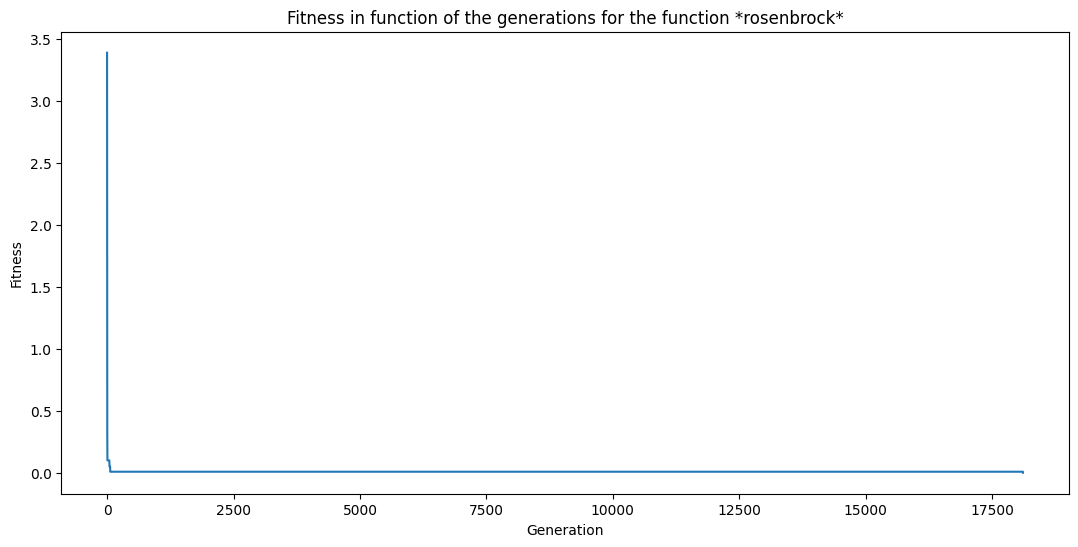

In [65]:
plt.figure(figsize=(13, 6))
plt.plot(generation_fitnesses)
plt.title(f"Fitness in function of the generations for the function *{fn_key}*")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

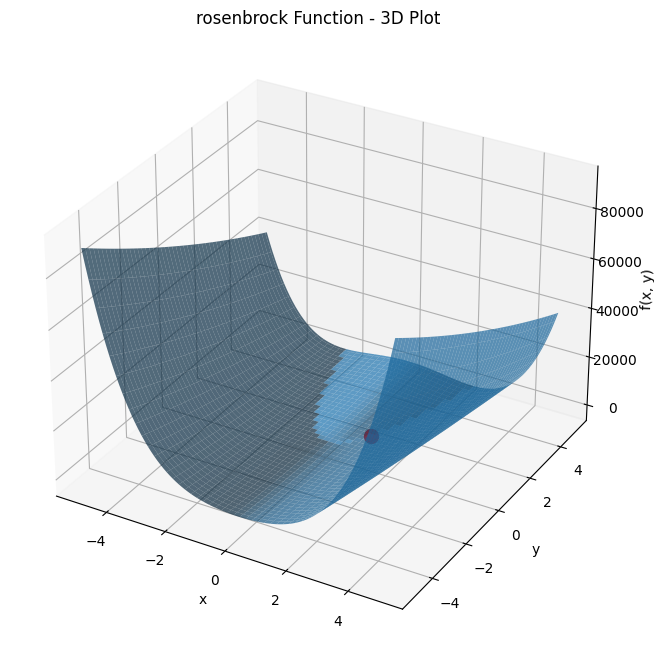

In [68]:
x_vals = np.linspace(lower, upper, 100)
y_vals = np.linspace(lower, upper, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = fn_dict[fn_key]['function'](X, Y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.7)
ax.scatter(*population[0].chromosome, fn_dict[fn_key]['function'](0, 0), color='red', s=100, label='Point (0, 0)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title(f'{fn_dict[fn_key]["function"].__name__} Function - 3D Plot')
plt.show()

We can see, on the plot above that the parameters the algorithm found seem to be the global minima of the *rosenbrock* function. Actually, when we look at Wikipedia, we see that the *rosenbrock* function finds its global minima at point $(1, 1)$. This point is pretty close that what the genetic algorithm found.

Feel free to try this notebook with the himmelbau function :)